In [1]:
from src.model import PyTradeShifts
from src.postprocessing import Postprocessing
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import os
os.chdir('../../')
print(os.getcwd())

/home/florian/Documents/GitHub/pytradeshifts


Next we calculate the trade communities for our base scenario as well as global catastrophic infrastructure loss and abrupt sunlight reduction.

In [2]:
base_year = 2022

base = PyTradeShifts(
    crop="Wheat",
    base_year=base_year,
    cd_kwargs={"seed": 2},
    make_plot=False,
)


nw_base = PyTradeShifts(
    crop="Wheat",
    base_year=base_year,
    scenario_file_name="nuclear_winter/xia_37tg_y3_swheat.csv",
    scenario_name="Nuclear Winter with All Countries",
    cd_kwargs={"seed": 2},
    make_plot=False,
)

nw1 = PyTradeShifts(
    crop="Wheat",
    base_year=base_year,
    scenario_file_name="nuclear_winter/xia_37tg_y3_swheat.csv",
    scenario_name="Without Pakistan and India",
    cd_kwargs={"seed": 2},
    make_plot=False,
    countries_to_remove=["Pakistan", "India"]
)

nw2 = PyTradeShifts(
    crop="Wheat",
    base_year=base_year,
    scenario_file_name="nuclear_winter/xia_37tg_y3_swheat.csv",
    scenario_name="Without United States and Russia",
    cd_kwargs={"seed": 2},
    make_plot=False,
    countries_to_remove=["United States", "Russia"]
)    

Loaded data for Wheat in Y2022.
Removed 1 countries with no trade or production.
Removed countries: ['South Sudan']
Prebalanced trade matrix.
Corrected re-exports.
Removed countries with trade below the 75th percentile.
Built trade graph.
Found 6 trade communities.
Loaded data for Wheat in Y2022.
Removed 1 countries with no trade or production.
Removed countries: ['South Sudan']
Prebalanced trade matrix.
Corrected re-exports.
Removed countries with trade below the 75th percentile.
Applied scenario Nuclear Winter with All Countries.
Built trade graph.
Found 7 trade communities.
Loaded data for Wheat in Y2022.
Removed 1 countries with no trade or production.
Removed countries: ['South Sudan']
Prebalanced trade matrix.
Corrected re-exports.
Removed 2 countries from the trade matrix.
Removed countries with trade below the 75th percentile.
Applied scenario Without Pakistan and India.
Built trade graph.
Found 7 trade communities.
Loaded data for Wheat in Y2022.
Removed 1 countries with no tr

To compare the scenario to each other, we have to do a bunch of additional calculations. These all happen in the postprocessing class. Anchor countries are user-specified list of countries that the script attempts to keep the same colour between scenarios.

In [3]:
comparison = Postprocessing([base, nw_base, nw1, nw2], anchor_countries=["Brazil", "United States", "Russia", "Uzbekistan" "Germany"])

Starting postprocessing computations...


In [4]:
scenario_network_df = {}
scenarios = ["base", "Base Nuclear Winter", "India/Pakistan", "United States/Russia"]
# Create an empty dataframe
network_df = pd.DataFrame(columns=['Scenario', "Country", 'Jaccard Distance', 'Wheat Imports Relative Difference'])
for i in range(1, 4):
    # Calculate the median for the jaccard distance
    jaccard_similarity = comparison.jaccard_indices[i]

    # Calculate the median for the imports relative difference
    imports_relative_difference = comparison.imports_difference[i-1]

    # Concat the data to the dataframe
    for country in jaccard_similarity.keys():
        temp_df = pd.DataFrame({
            'Scenario': scenarios[i],
            'Country': country,
            'Jaccard Distance': 1 - jaccard_similarity[country],
            'Wheat Imports Relative Difference': imports_relative_difference[country]
        }, index=[0])
        network_df = pd.concat([network_df, temp_df], ignore_index=True)
    scenario_network_df[scenarios[i]] = network_df
# Concatenate the dataframes
network_df = pd.concat([scenario_network_df["Base Nuclear Winter"], scenario_network_df["India/Pakistan"], scenario_network_df["United States/Russia"]], ignore_index=True)

/tmp/ipykernel_72309/1167750762.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  network_df = pd.concat([network_df, temp_df], ignore_index=True)


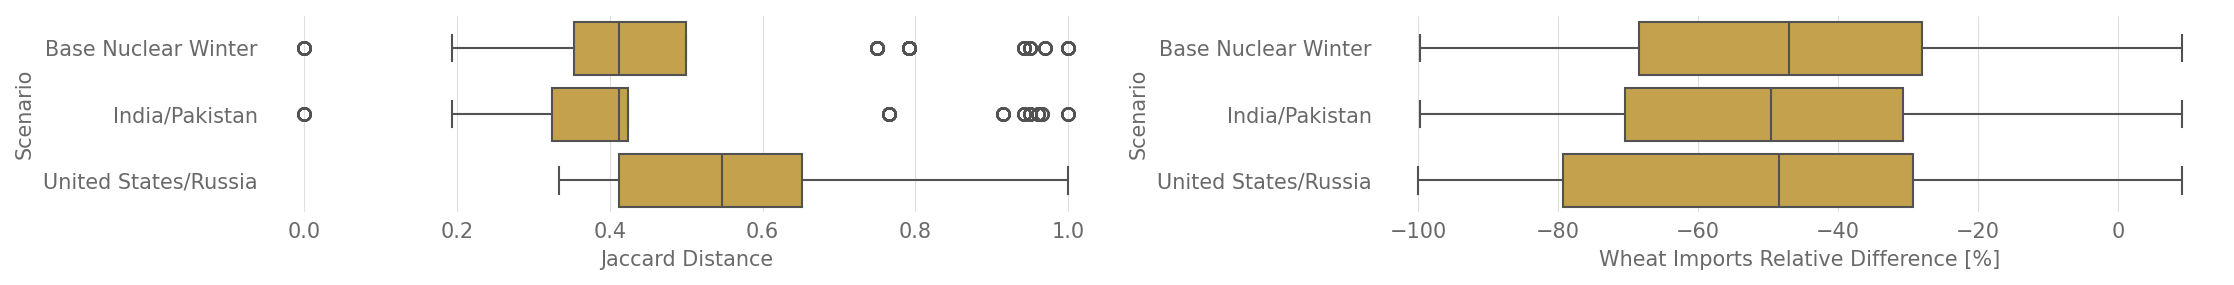

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(15, 2))
sns.boxplot(y='Scenario', x='Jaccard Distance', data=network_df, ax=axes[0], color = "#d6a93a")
sns.boxplot(y='Scenario', x='Wheat Imports Relative Difference', data=network_df, ax=axes[1], color = "#d6a93a")
axes[0].set_xlabel("Jaccard Distance")
axes[1].set_xlabel("Wheat Imports Relative Difference [%]")
fig.tight_layout()

Next lets look at how the trade communities change globally in the different scenarios. 

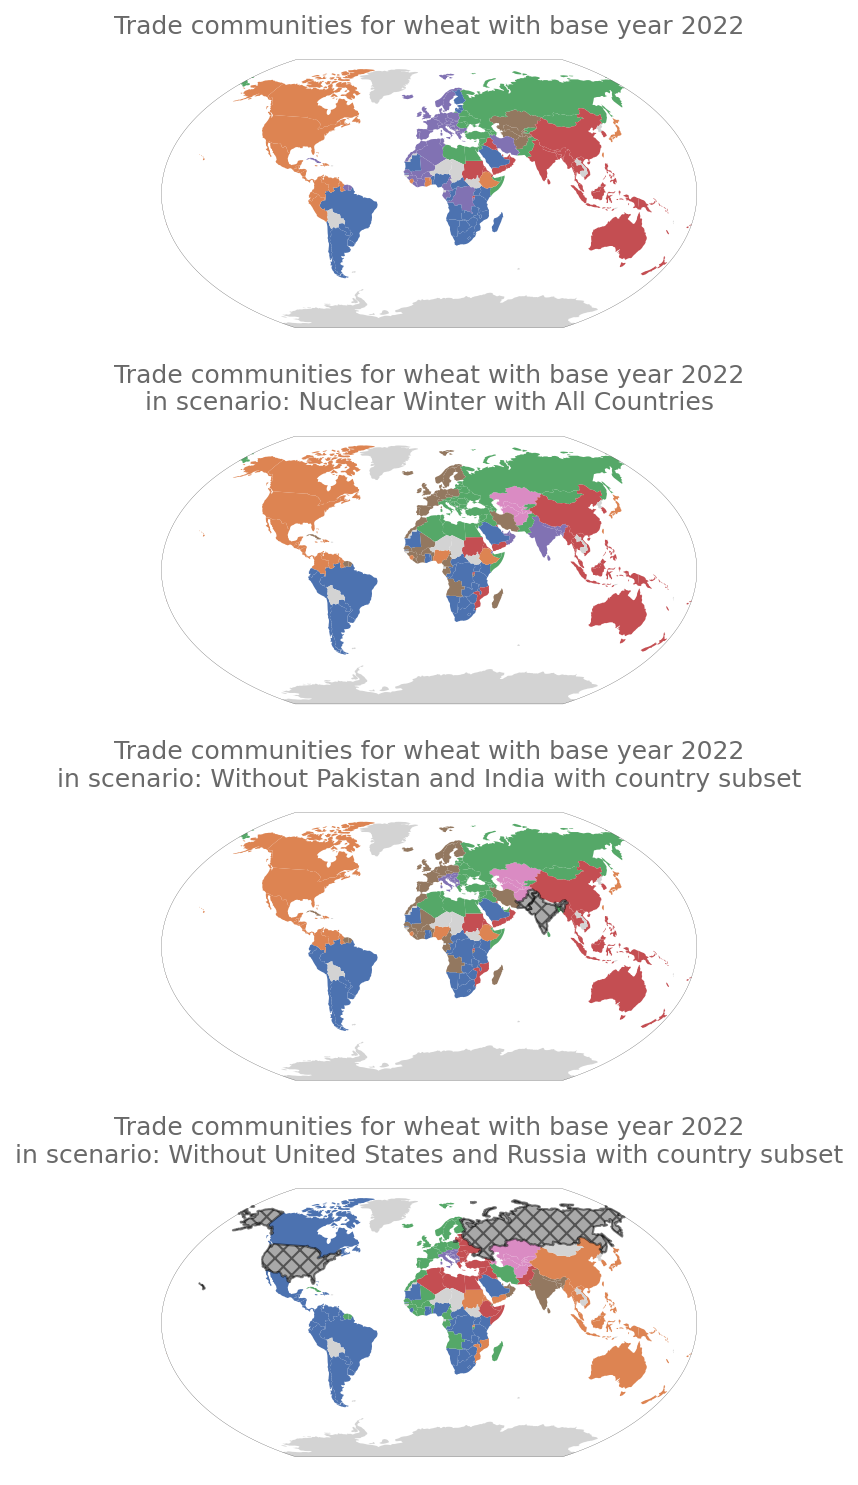

In [6]:
comparison.plot_all_trade_communities(figsize=(15, 10))

We can also try to quantify how different the communities are in each scenario for each country.
The natural way of doing this is the [Jaccard index](https://en.wikipedia.org/wiki/Jaccard_index)
It measures the similarity between two sets.
So for each country we can compute a Jaccard distance (1-Jaccard index)
showing us by how much for each country their community changed in comparison with the base scenario.

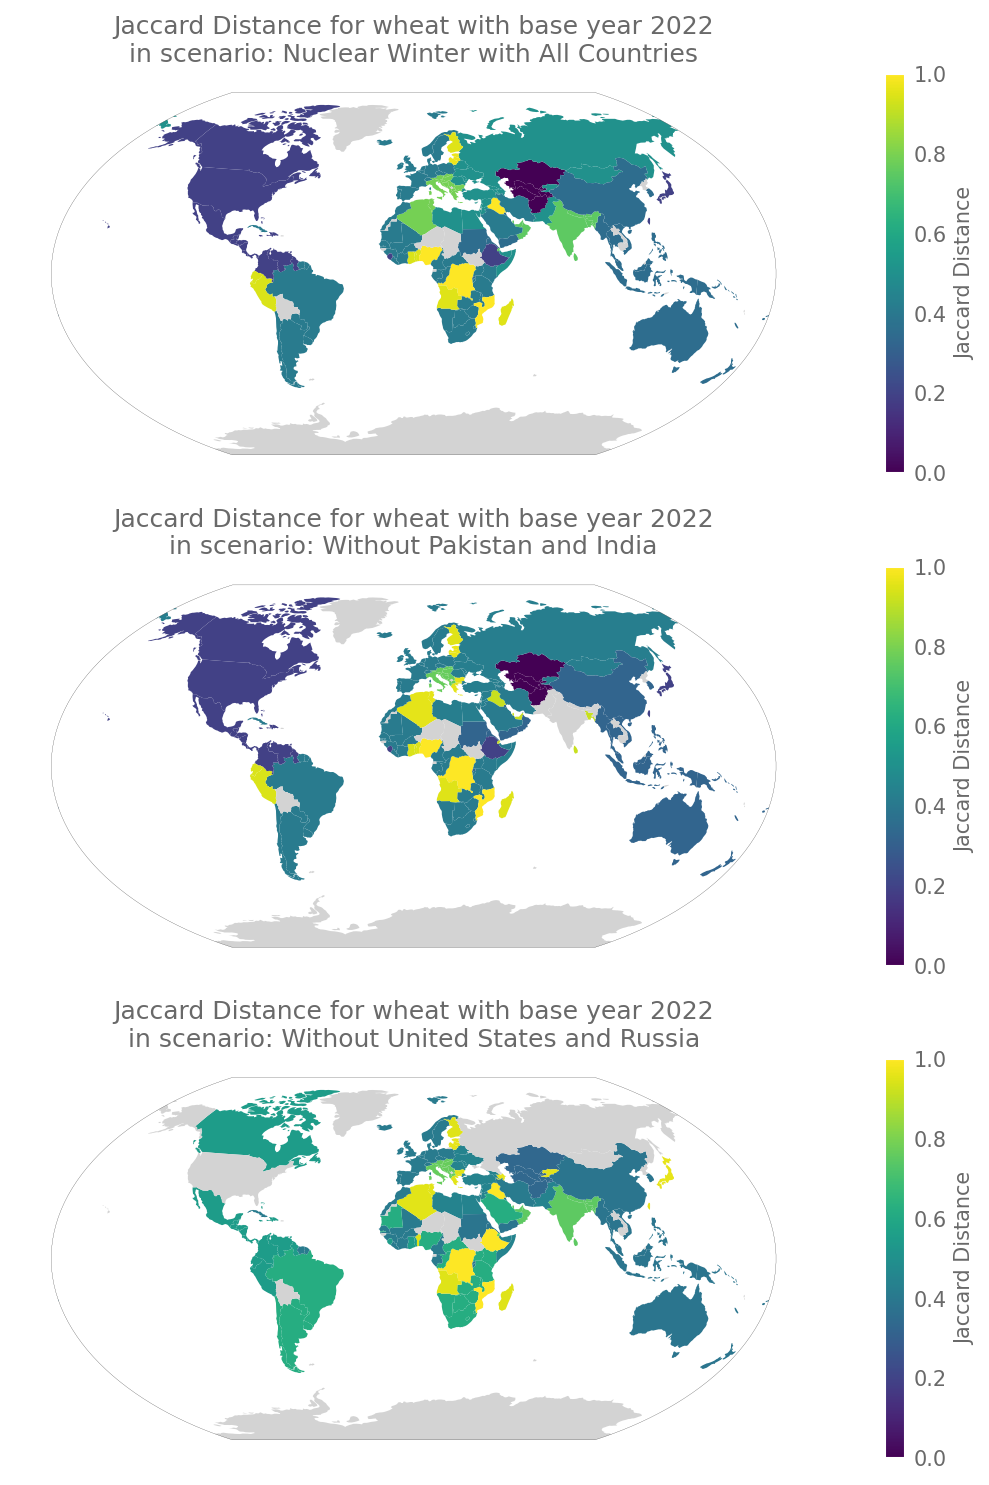

In [7]:
comparison.plot_community_difference(figsize=(10, 10), vmin=0, vmax=1)

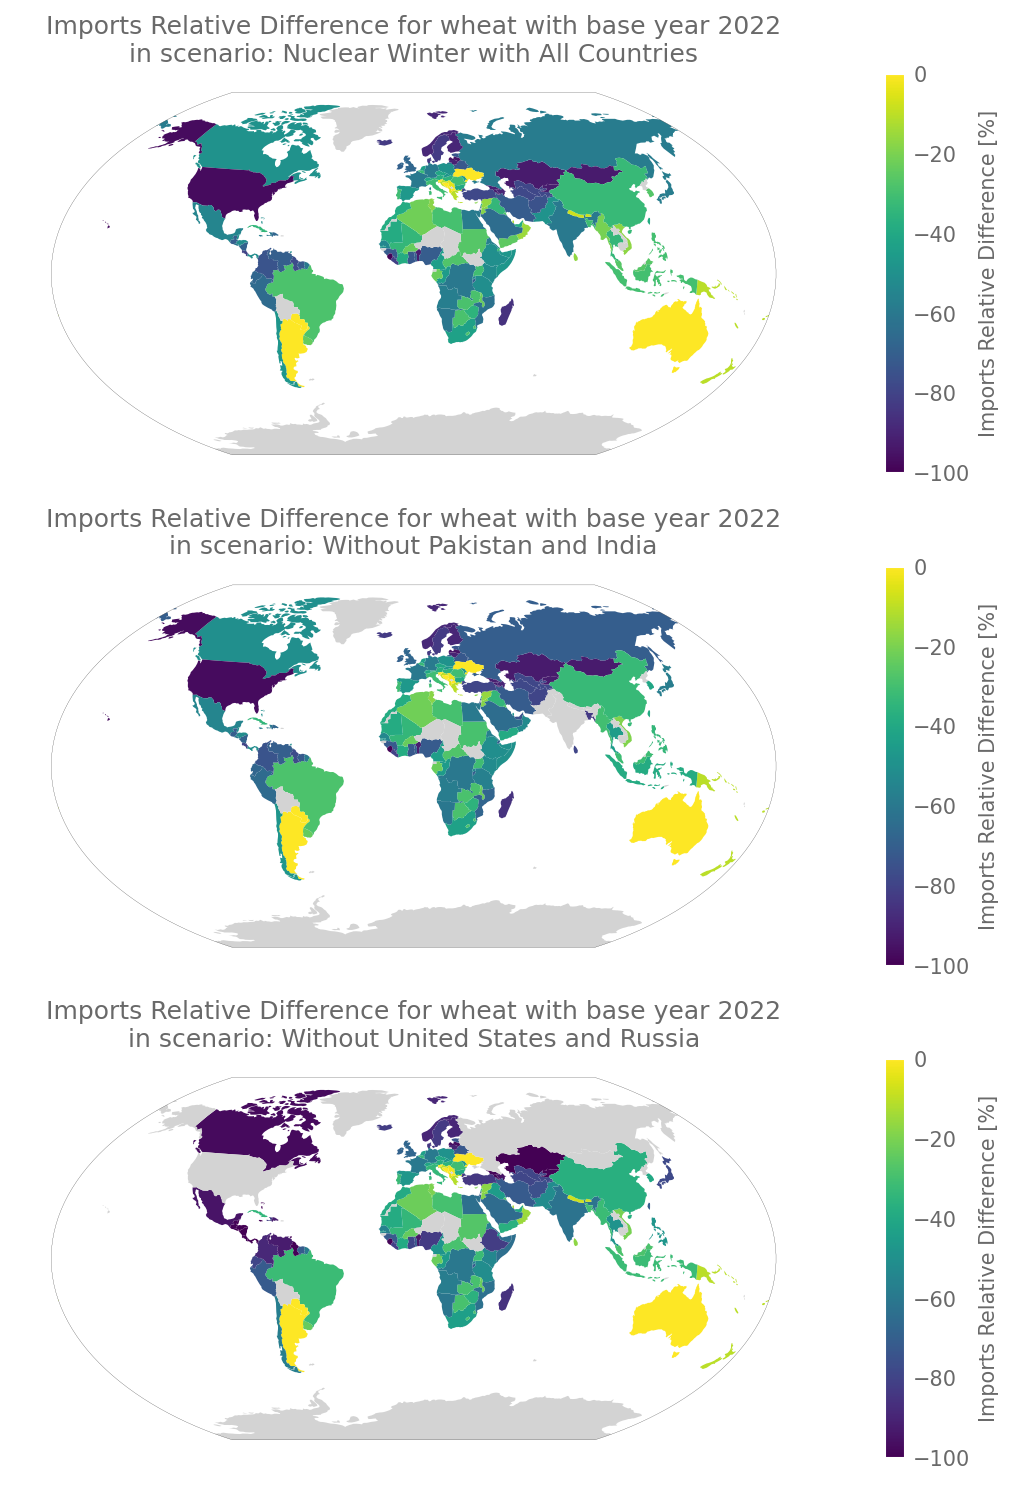

In [8]:
comparison.plot_imports_difference(figsize=(10, 10), vmin=-100, vmax=0)

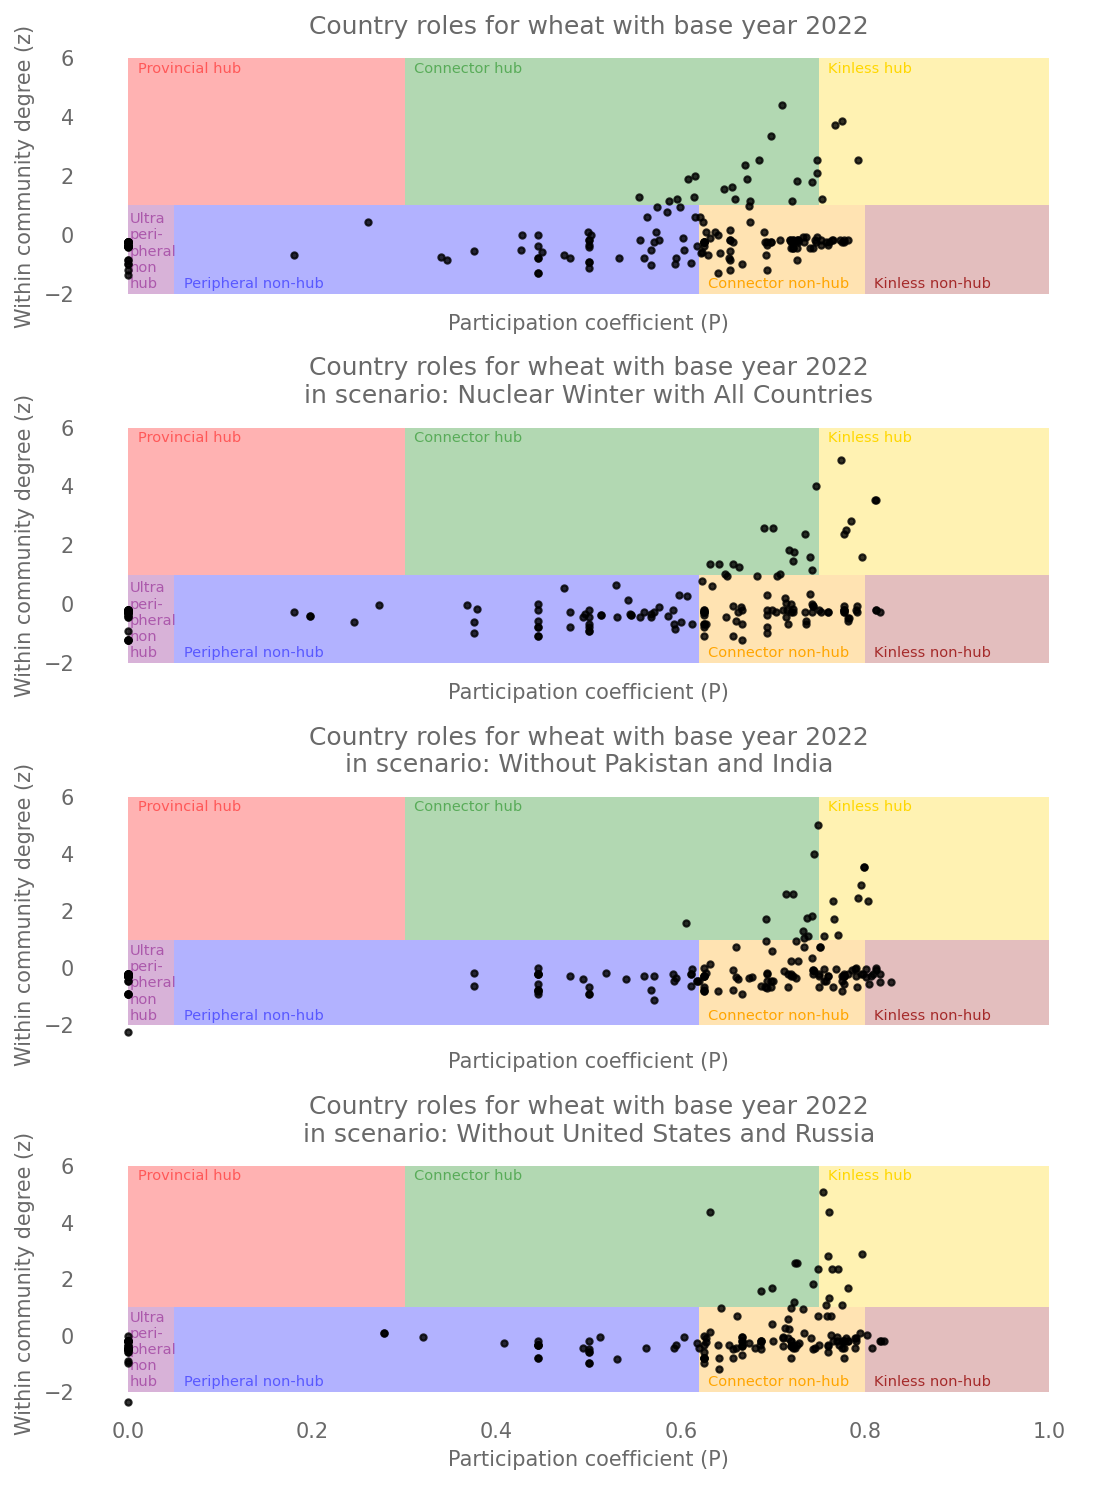

In [9]:
comparison.plot_roles()

We can also study the degree centralities (in and out) for all networks:

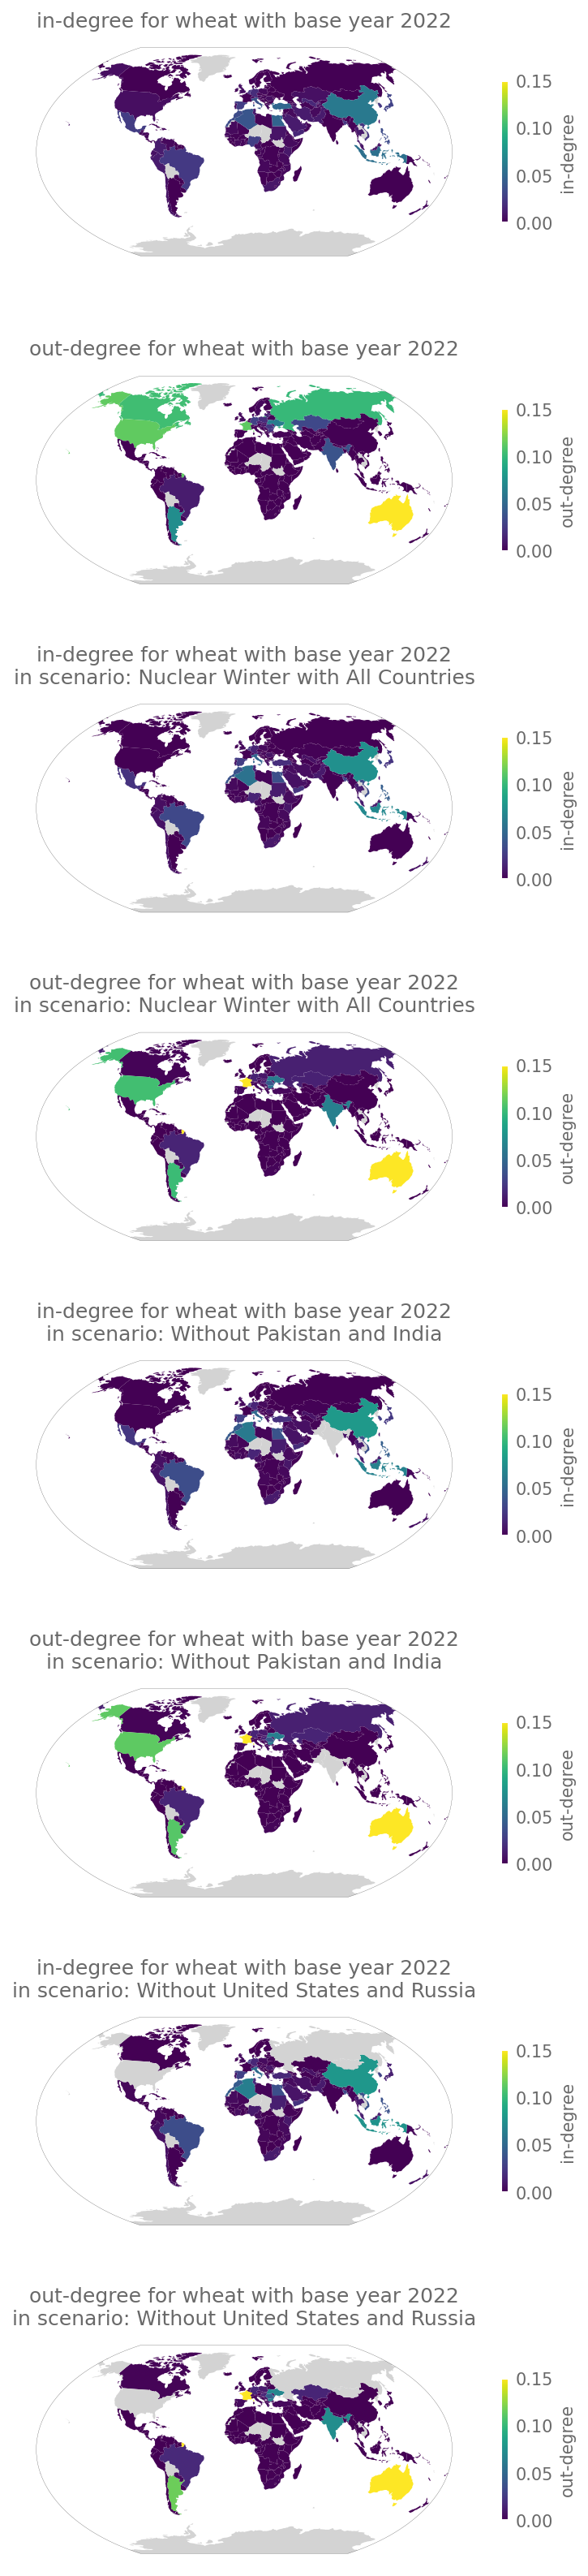

In [10]:
comparison.plot_centrality_maps(figsize=(5, 25), shrink=0.2, vmin=0, vmax=0.15)

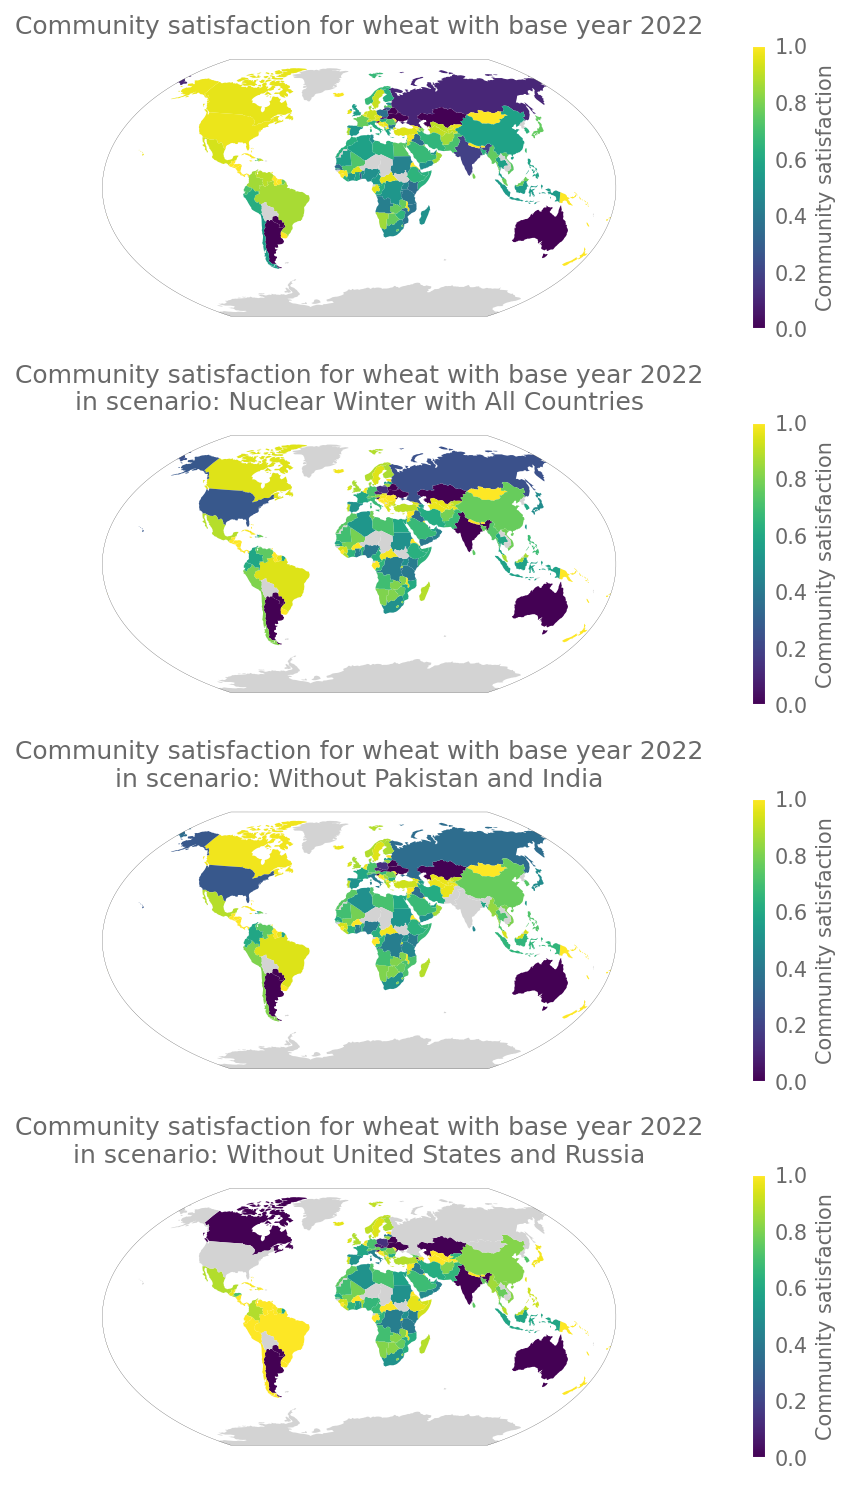

In [11]:
comparison.plot_community_satisfaction(figsize=(15, 10))

and the difference from base scenario:

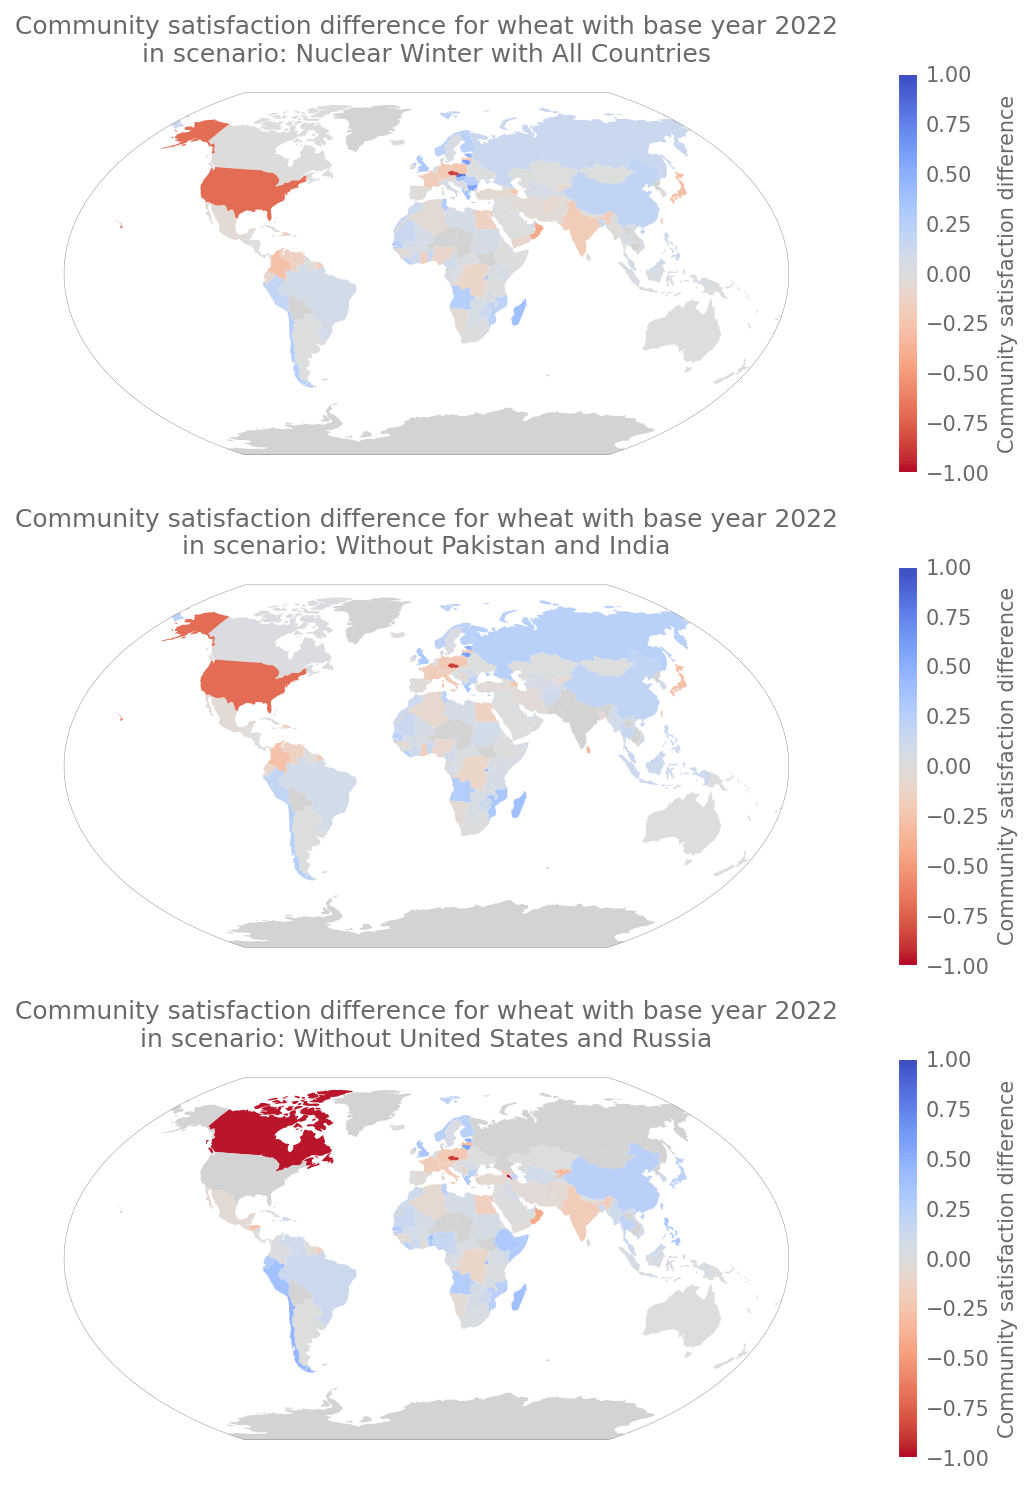

In [12]:
comparison.plot_community_satisfaction_difference(figsize=(10,10), vmin=-1, vmax=1, cmap="coolwarm_r")

We also can look at country's stability index, which is a measure of how easily each country can replace their import partners (same paper as community satisfaction).

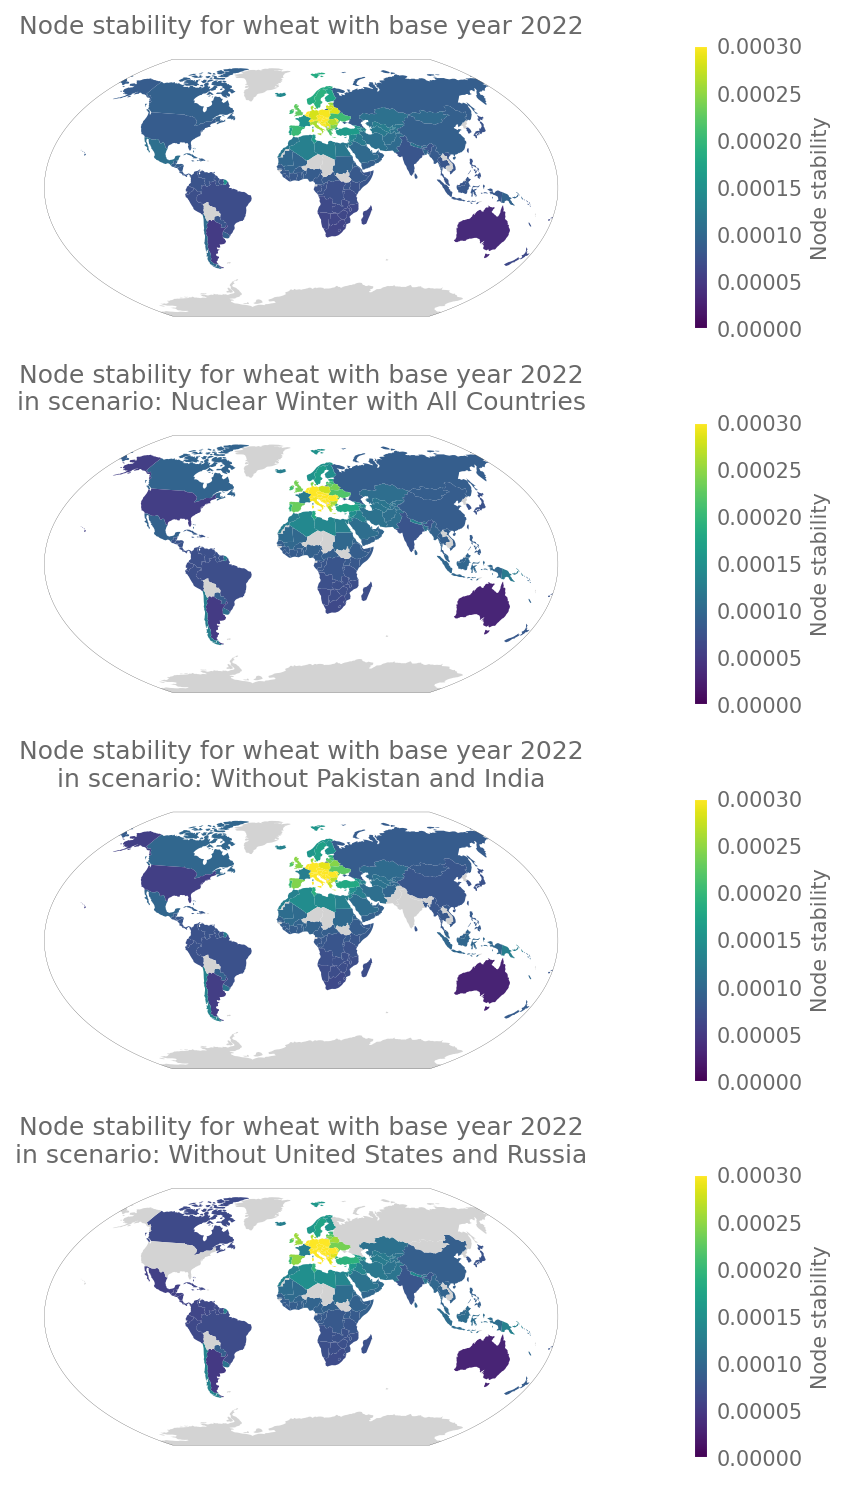

In [13]:
comparison.plot_node_stability(figsize=(15, 10), vmin=0, vmax=0.0003) # figsize works here too of course

The units are dimensionless, so it is better to look at the relative change of the node stability to get a better view. 
For this reason we can look at the *relative* change of this metric:

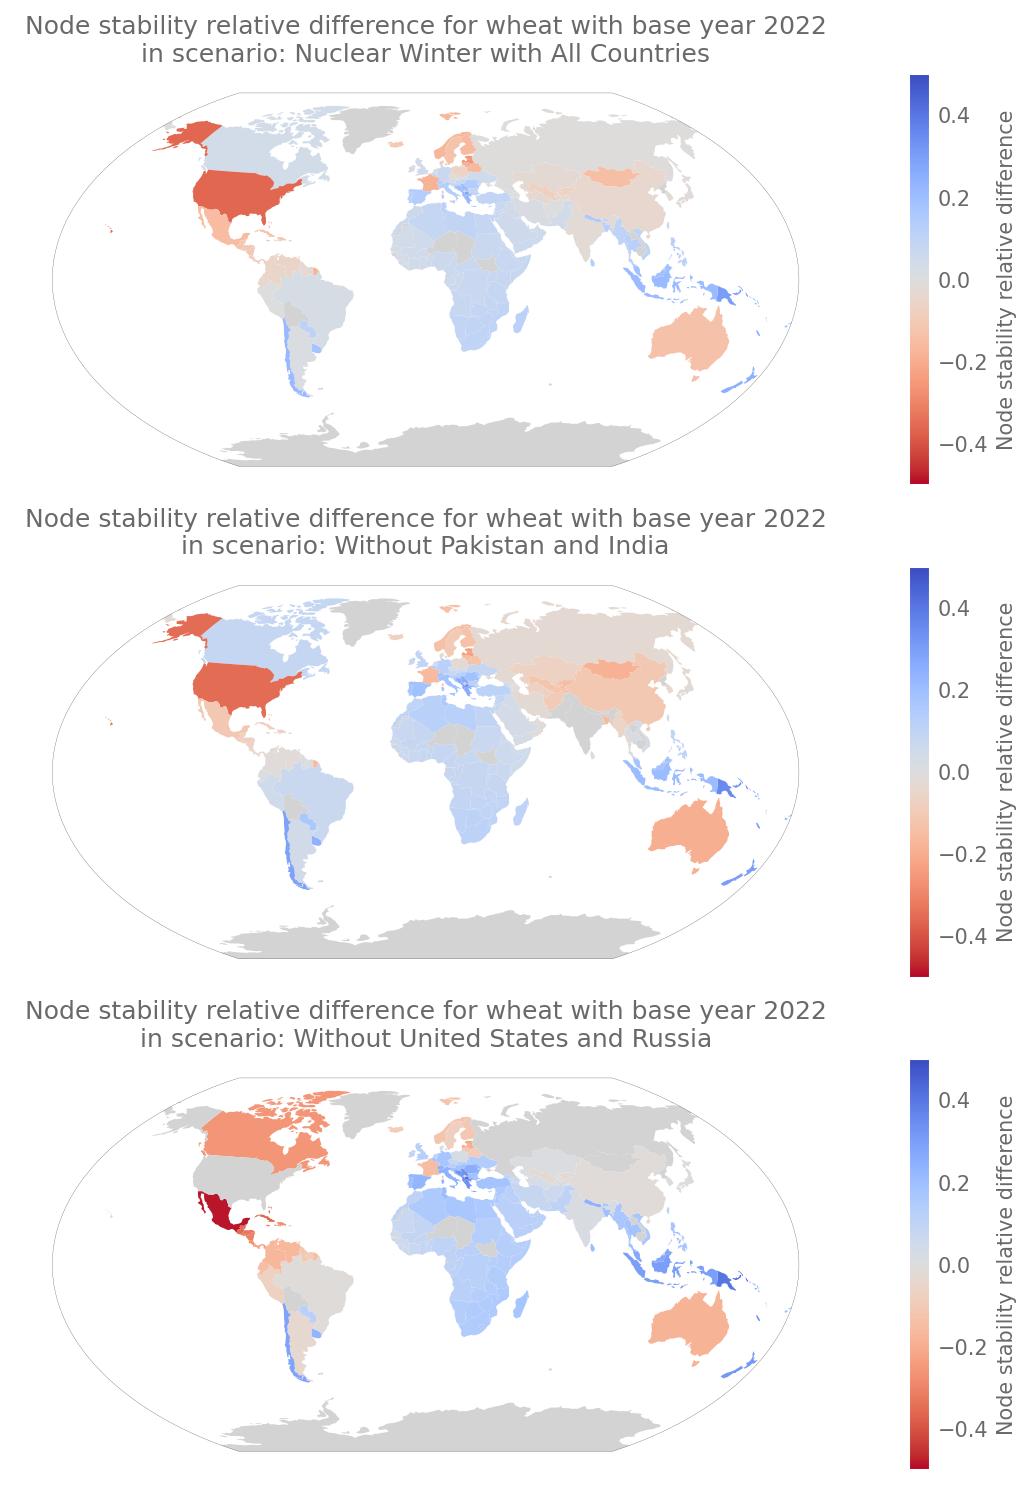

In [14]:
comparison.plot_node_stability_difference(figsize=(10, 10), vmin=-0.5, vmax=0.5, cmap="coolwarm_r")

Another important aspect of a network is its resilience to attacks, and we can see that as well:

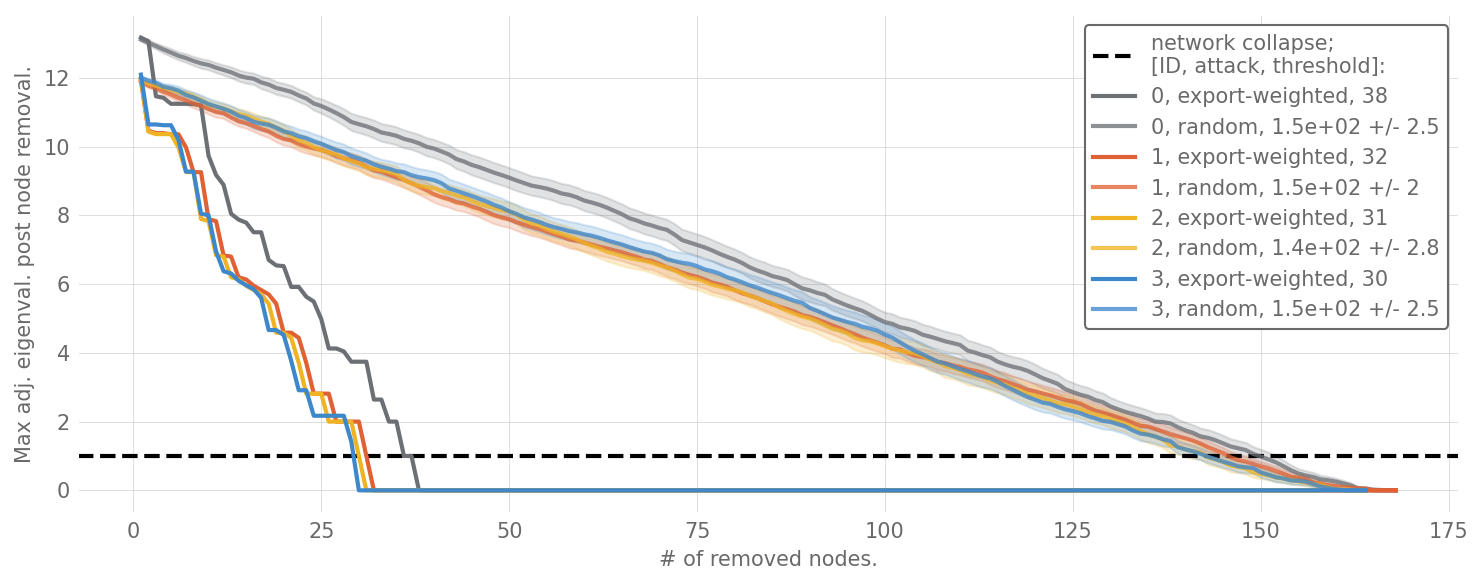

In [15]:
comparison.plot_attack_resilience(exclude_attacks="entropic")